### Run lisflood with updates to H in orthographic projection (m)

In this notebook we'll test the following:
- run lisflood for one time step with some inital state
- then add some meters of water depth everywhere
- run it for several stepsto get water flowing through the mesh


In [1]:
%matplotlib inline
from bmi.wrapper import BMIWrapper
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [2]:
def update_water_level(wrapper, dhdt):
    """
    update the water level in the model with the given rate in m/s
    
    :param wrapper: BMI wrapper of the model
    :param dhdt: change in water level in m/s (i.e. infiltration rate should be negative)
    
    """
    
    wrapper.get_var("H")[:] = np.maximum(wrapper.get_var("H")[:] + wrapper.get_time_step()*dhdt, 0)
    

### start your engines
Let's first start up a very small 500m resolution model, with just a few pixels wide and quite a lot more pixels long. The .par file such that no water flows into the model, no water flows out, and it starts with a layer of 1 meter of water in some places. This is purely to have some water to get rid of.

In [3]:
wrapper = BMIWrapper(engine="/home/hcwinsemius/lisflood/liblisflood.so", configfile='/home/hcwinsemius/git/barotse/example_models/LFP_synthetic_2D_ortho/LFP_syntheticTestCase_2D.par')
wrapper.initialize()
# let's do a couple of time steps
for n in range(6):
    wrapper.update()


Let's plot the terrain data of the model

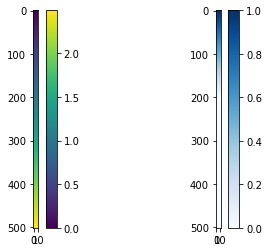

In [4]:
dem = wrapper.get_var("DEM")
d = wrapper.get_var("H").copy()
h = dem + d
plt.figure()
plt.subplot(121)
plt.imshow(dem)
plt.colorbar()
plt.subplot(122)
plt.imshow(d, cmap="Blues")
plt.colorbar()

let's make a side plot with both the terrain and the water level! (so depth+terrain)

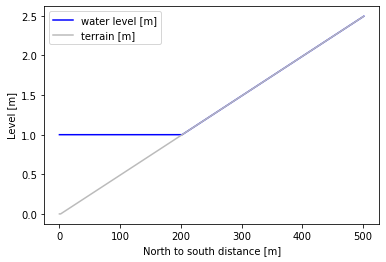

In [5]:
plt.plot(h[:, 5], color="b", label="water level [m]")
plt.plot(dem[:, 5], color="#BBBBBB", label="terrain [m]")
plt.ylabel("Level [m]")
plt.xlabel("North to south distance [m]")
plt.legend()

### Experiment 
We will:
* Run the model for about a day, and every time step, subtract infiltration rates where available (if depth is zero, no infiltration)
* After aday: store the water level over one north-south line
* Do this for several days
* Evaluate how water depths change in time


In [6]:
infiltration_rate = 0.1 # m per day
dhdt = -infiltration_rate/86400 # m per second
# make an empty list, which we will later fill with water levels from the model
hs = []
t_write = 0  # current moment to write hs to list
t_interval = 86400  # let's write water levels once a day, you can change this to 3600 for once per hour
# get the water level from the model. Copy to a new variable.
# h_orig = wrapper.get_var("H").copy()
# wrapper.update()
ts = np.arange(50) * t_interval
print(ts)

print(wrapper.get_current_time())
for t_write in tqdm(ts):
    while wrapper.get_current_time() < t_write:
        update_water_level(wrapper, dhdt)
        wrapper.update()
    # append one water level in the domain to the empty list
    hs.append(wrapper.get_var("H").copy())
#     t_write += t_interval  # increase the writing moment with interval
print(wrapper.get_current_time())


[      0   86400  172800  259200  345600  432000  518400  604800  691200
  777600  864000  950400 1036800 1123200 1209600 1296000 1382400 1468800
 1555200 1641600 1728000 1814400 1900800 1987200 2073600 2160000 2246400
 2332800 2419200 2505600 2592000 2678400 2764800 2851200 2937600 3024000
 3110400 3196800 3283200 3369600 3456000 3542400 3628800 3715200 3801600
 3888000 3974400 4060800 4147200 4233600]
670.5963283386815


  0%|          | 0/50 [00:00<?, ?it/s]

4233691.892686877


Text(0.5, 0, 'north-south distance')

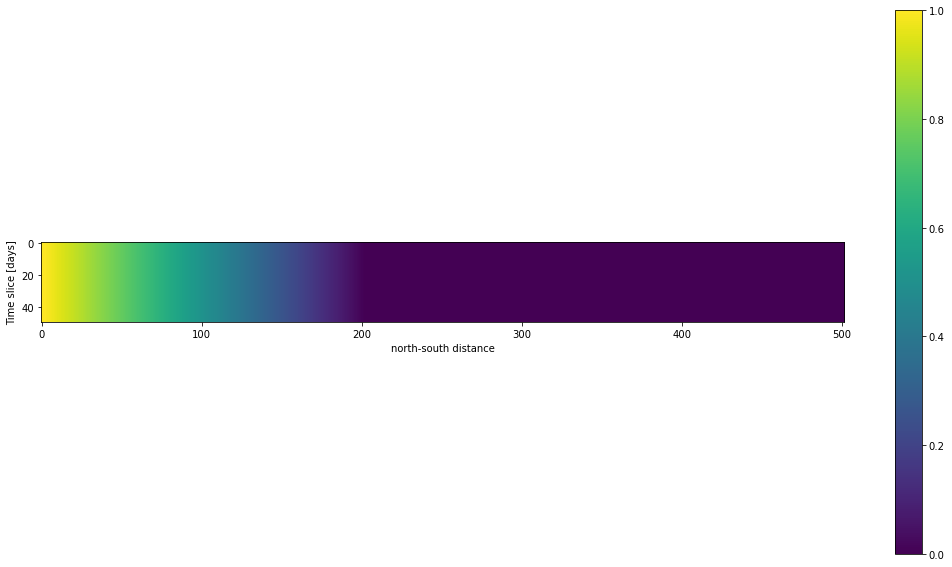

In [7]:
fig, axs = plt.subplots(figsize=(18, 10))
p = axs.imshow(np.array(hs)[:,:,5])
plt.colorbar(p)
plt.ylabel("Time slice [days]")
plt.xlabel("north-south distance")

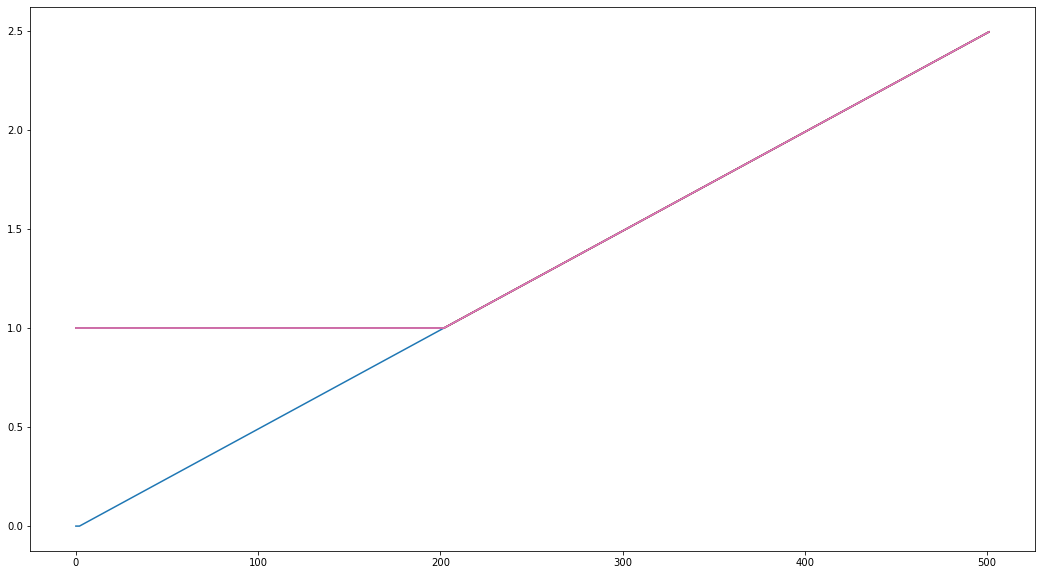

In [9]:
plt.figure(figsize=(18, 10))
plt.plot(dem[:, 5], label="dem")
for h_ in hs[0:6]:
    plt.plot(h_[:,5]+dem[:,5])

# print((h_orig).sum())
# for h_ in hs:
#     print((h_).mean())

